In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [2]:
data = pd.read_csv('kc_house_data.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

In [3]:
np.random.seed(42)
data.loc[data.sample(frac=0.05).index, 'sqft_lot'] = np.nan
data.loc[data.sample(frac=0.05).index, 'bathrooms'] = np.nan 

data[['sqft_lot', 'bathrooms']].isnull().sum()

sqft_lot     1081
bathrooms    1081
dtype: int64

Task 1: Introduce missing values in 'sqft_lot' and 'bathrooms' columns

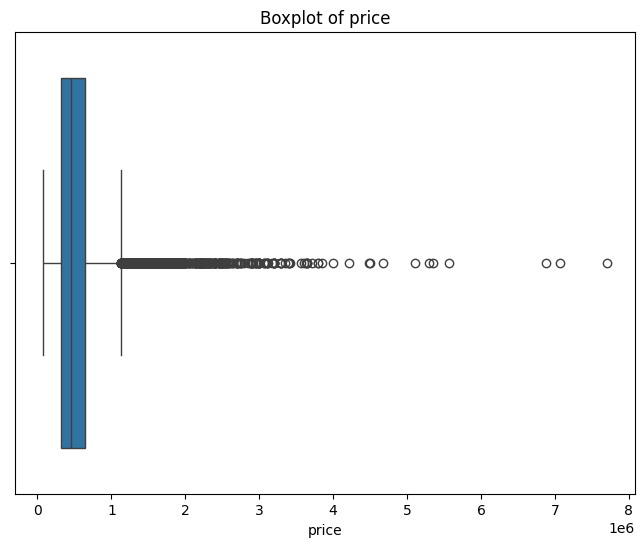

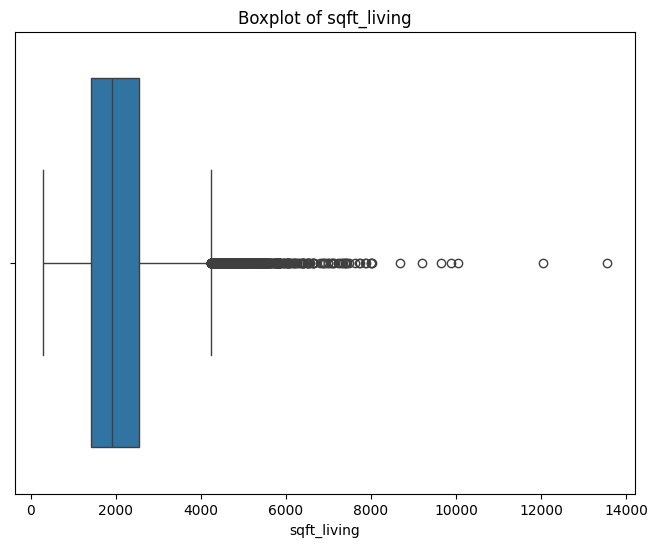

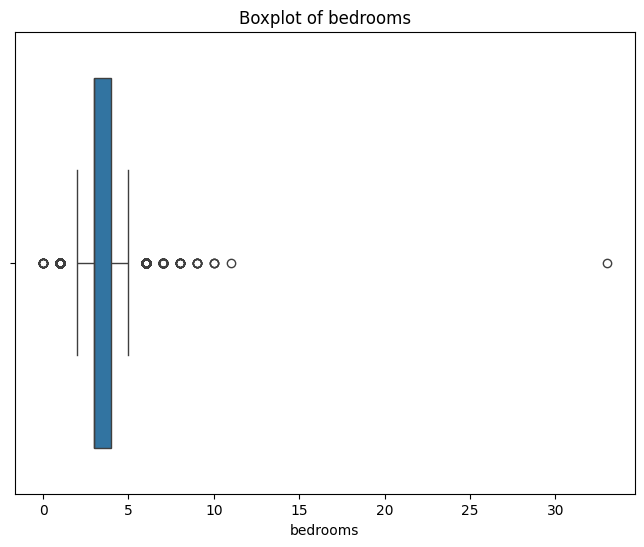

In [4]:
for col in ['price', 'sqft_living', 'bedrooms']:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=data[col])
    plt.title(f'Boxplot of {col}')
    plt.show()

def remove_outlier(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_cleaned = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df_cleaned


data = remove_outlier(data, 'price')
data = remove_outlier(data, 'sqft_living')
data = data[data['bedrooms'] < 30]

In [5]:
data['date'] = pd.to_datetime(data['date'])

data['sale_year'] = data['date'].dt.year
data['sale_month'] = data['date'].dt.month
data['house_age'] = data['sale_year'] - data['yr_built']

data['was_renovated'] = (data['yr_renovated'] != 0).astype(int)
data['age_since_renovation'] = np.where(data['was_renovated'] == 1, data['sale_year'] - data['yr_renovated'], data['house_age'])

data['sqft_living_per_floor'] = data['sqft_living'] / data['floors'] 
data['bath_per_bed'] = data['bathrooms'] / data['bedrooms'].replace(0, np.nan)

data = data.drop('date', axis=1)

Task 2: Build a Sophisticated Preprocessing Pipeline

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

X = data.drop('price', axis=1)
y = data['price']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

numerical_features = ['sqft_living', 'sqft_lot', 'bathrooms', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15', 'house_age', 'age_since_renovation', 'sqft_living_per_floor', 'bath_per_bed']
categorical_features = ['zipcode']
passthrough_features = ['grade', 'condition', 'was_renovated']


numerical_pipeline = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])

categorical_pipeline = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])


preprocessor = ColumnTransformer(transformers=[('num', numerical_pipeline, numerical_features), ('cat', categorical_pipeline, categorical_features), ('pass', 'passthrough', passthrough_features)], remainder='drop')


Task 3: Model Training and Hyperparameter Tuning 

In [7]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline

models = {'RandomForest': RandomForestRegressor(random_state=42), 'GradientBoosting': GradientBoostingRegressor(random_state=42), 'XGBoost': XGBRegressor(random_state=42)}


best_models = {}
for name, model in models.items():
    print(f"Tuning {name}...")
    
    final_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', model)])

    param_grid = {}
    if name == 'RandomForest':
        param_grid = {'regressor__n_estimators': [100, 200], 'regressor__max_depth': [None, 10, 20]}
    elif name == 'GradientBoosting':
        param_grid = {'regressor__n_estimators': [100, 200], 'regressor__learning_rate': [0.05, 0.1]}
    elif name == 'XGBoost':
        param_grid = {'regressor__n_estimators': [100, 200],'regressor__learning_rate': [0.05, 0.1]}
    
    grid_search = GridSearchCV(final_pipeline, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)
    
    best_models[name] = grid_search
    print(f"Best parameters for {name}: {grid_search.best_params_}")
    print(f"Best cross-validation score for {name}: {abs(grid_search.best_score_)**0.5}")

overall_best_model = None
best_rmse = float('inf')
for name, grid_search in best_models.items():
    current_rmse = abs(grid_search.best_score_)**0.5
    if current_rmse < best_rmse:
        best_rmse = current_rmse
        overall_best_model = grid_search.best_estimator_

print(f"\nOverall best model is {overall_best_model.named_steps['regressor']}")


Tuning RandomForest...
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best parameters for RandomForest: {'regressor__max_depth': None, 'regressor__n_estimators': 200}
Best cross-validation score for RandomForest: 96633.75422086625
Tuning GradientBoosting...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best parameters for GradientBoosting: {'regressor__learning_rate': 0.1, 'regressor__n_estimators': 200}
Best cross-validation score for GradientBoosting: 92781.53069220905
Tuning XGBoost...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best parameters for XGBoost: {'regressor__learning_rate': 0.1, 'regressor__n_estimators': 200}
Best cross-validation score for XGBoost: 85589.58074536585

Overall best model is XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_m

Final R-squared ($R^2$) Score: 0.8278
Final Mean Absolute Error (MAE): 60642.99
Final Root Mean Squared Error (RMSE): 84261.90
Percentage improvement over original model: 59.83%


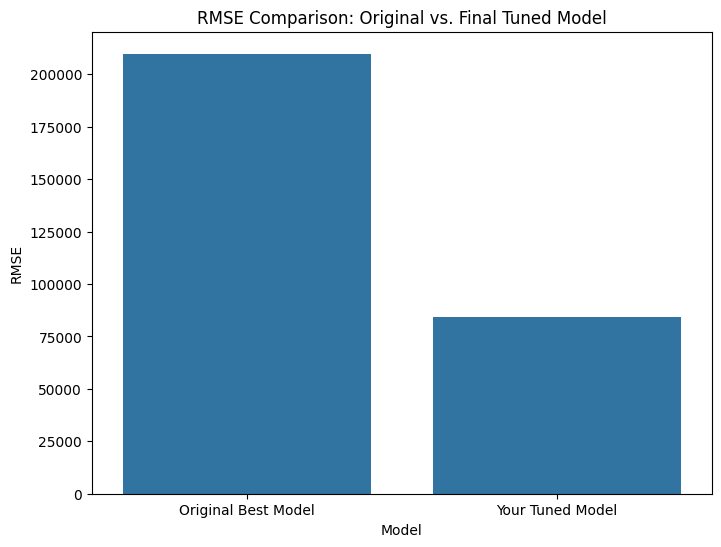

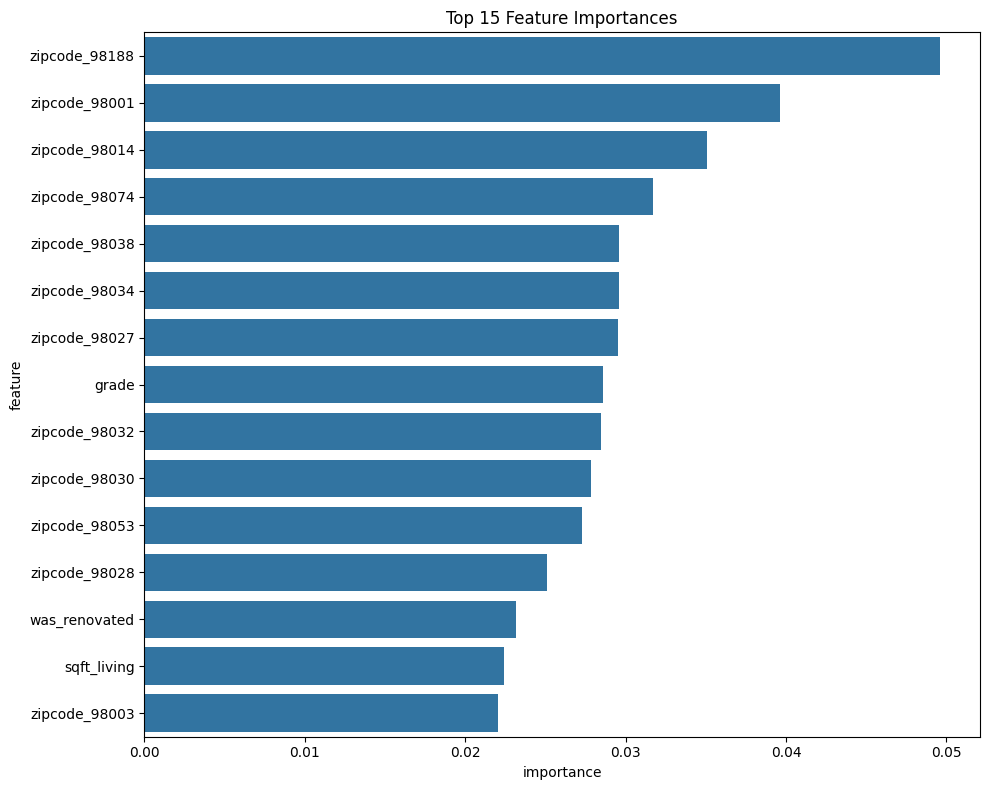


Top 5 Most Important Features:
          feature  importance
81  zipcode_98188    0.049618
14  zipcode_98001    0.039657
24  zipcode_98014    0.035078
51  zipcode_98074    0.031708
37  zipcode_98038    0.029618


In [10]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

final_best_pipeline = overall_best_model


y_pred = final_best_pipeline.predict(X_test)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"Final R-squared ($R^2$) Score: {r2:.4f}")
print(f"Final Mean Absolute Error (MAE): {mae:.2f}")
print(f"Final Root Mean Squared Error (RMSE): {rmse:.2f}")


original_rmse = 209786.255677
percentage_improvement = ((original_rmse - rmse) / original_rmse) * 100
print(f"Percentage improvement over original model: {percentage_improvement:.2f}%")

results = pd.DataFrame({'Model': ['Original Best Model', 'Your Tuned Model'], 'RMSE': [original_rmse, rmse]})
plt.figure(figsize=(8, 6))
sns.barplot(x='Model', y='RMSE', data=results)
plt.title('RMSE Comparison: Original vs. Final Tuned Model')
plt.show()

if isinstance(final_best_pipeline.named_steps['regressor'], (RandomForestRegressor, XGBRegressor)):
    regressor = final_best_pipeline.named_steps['regressor']
    
    feature_names = []
    
    feature_names.extend(numerical_features)
    feature_names.extend(passthrough_features)
    
    
    ohe_features = final_best_pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
    feature_names.extend(ohe_features)
    
    
    importances = regressor.feature_importances_
    
    
    feature_importances_df = pd.DataFrame({'feature': feature_names, 'importance': importances }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(10, 8))
    sns.barplot(x='importance', y='feature', data=feature_importances_df.head(15))
    plt.title('Top 15 Feature Importances')
    plt.tight_layout()
    plt.show()
    
    
    top_5_features = feature_importances_df.head(5)
    print("\nTop 5 Most Important Features:")
    print(top_5_features)
    


Brief summary:


The machine learning pipeline, a tuned XGBoostRegressor, was successfully evaluated on the test set.
The model achieved a significant R^2 score and low error rates, indicating a strong predictive performance. 

An analysis of feature importance revealed that a few specific zip codes, were the most influential factors in predicting house prices. This highlights the importance of location and neighborhood in the real estate market.